# Vibrational strong coupling with CavMD 

Here, we introduce how to use MaxwellLink to run cavity molecular dynamics (CavMD) simulations of liquid water under vibrational strong coupling.

## 1. Setting up the socket communication layer

Using the TCP socket requires to set the `hostname` and `port number`. In local machines, we can use the helper function `get_available_host_port()` from **MaxwellLink** to obtain these two pieces of information. Then, we initialize a `SocketHub` instance to provide the socket communication in **MaxwellLink**.

In [1]:
import numpy as np
import maxwelllink as mxl
from maxwelllink import sockets as mxs

try:
    import meep as mp
except ImportError as exc:  
    raise RuntimeError(
        "Meep is required for this tutorial."
        "Install via conda: conda install -c conda-forge pymeep=*=mpi_mpich_*"
    ) from exc

address = "socket_cavmd"
hub = mxl.SocketHub(unixsocket=address, timeout=10.0, latency=1e-5)

Using MPI version 4.1, 1 processes


## 2. Bind Molecule and EM solver to the SocketHub

Then, we create a `Molecule` instance to define the information of this molecule in the EM simulation environment. We also need to setup the EM solver (**MEEP**) as a classical single mode cavity using `mxl.SingleModeSimulation`.

In [2]:
# the rescaling 0.73 is to account for the difference between the TIP4P water model verus that from a straightforward
# sum_i Q_i * r_i calculation, where the oxygen atom is used for the position instead of using the M charge site.
# In other words, the dipole and dmudt calculation from MD driver needs to be rescaled by 0.73 to match the real TIP4P
# water model values (used in i-pi CavMD).
molecule = mxl.Molecule(
    hub=hub,
    rescaling_factor=0.73,
)

au_to_cminverse = 219474.63

frequency_au = 3550 / au_to_cminverse
coupling_strength = 4e-4
print(f"Coupling strength: {coupling_strength:.3e} au")
damping_au = 0e-4
au_to_fs = 41.3413745758
dt_au = 0.5 * au_to_fs

angstrom_to_au = 1.8897259886

# use the info of the water molecule to construct unexcited photon state
# z-axis info is not used since the cavity is only coupled to x and y directions
dipole_initial = [16.704, -18.040, 0.0]
dmudt_initial = [-0.00355972,  0.01098518, 0.0]
qc_initial = -np.array(dipole_initial) * coupling_strength / frequency_au**2

sim = mxl.SingleModeSimulation(
    hub=hub,
    molecules=[molecule],
    frequency_au=frequency_au,
    coupling_strength=coupling_strength,
    damping_au=damping_au,
    coupling_axis="xy",
    drive=0.0,
    dt_au=dt_au,
    qc_initial=qc_initial,
    mu_initial=dipole_initial,
    dmudt_initial=dmudt_initial,
    record_history=True,
    include_dse=True,
)


[Init Molecule] Under socket mode, registered molecule with ID 0
Coupling strength: 4.000e-04 au


## 3. Python way to lunch LAMMPS on a separate terminal

Generally, using the Socket Interface requires to launch the EM simulation in one terminal and then start the molecular driver simulation in a separate terminal. To avoid openning a second terminal, below we introduce a python helper function `launch_lmp(...)`, which will launch LAMMPS (the `lmp_mxl` binary file) from Python (so we can stay within this notebook to finish this tutorial). 

The LAMMPS code performs a 10-ps NVE liquid water simulation. The `fix mxl` command in the LAMMPS input file communicates between LAMMPS and MaxwellLink.

In a 2021 MacBook Pro M1, this simulation takes approximately 1.5 minutes.

In [3]:
import shlex
import subprocess
import time


def launch_lmp(address: str, sleep_time: float = 0.5):
    cmd = (
        f"./lmp_input/launch_lmp_xml.sh {address} "
    )
    print('Launching LMP via subprocess...')
    print('If you prefer to run it manually, execute:')
    print('  ' + cmd)
    argv = shlex.split(cmd)
    proc = subprocess.Popen(argv)
    time.sleep(sleep_time)
    return proc

launch_lmp(address)

sim.run(steps=20000)    

Launching LMP via subprocess...
If you prefer to run it manually, execute:
  ./lmp_input/launch_lmp_xml.sh socket_cavmd 
Preparing LAMMPS input files with port socket_cavmd...
LAMMPS (29 Aug 2024 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (35.233 35.233 35.233)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  648 atoms
  scanning bonds ...
  2 = max bonds/atom
  scanning angles ...
  1 = max angles/atom
  orthogonal box = (0 0 0) to (35.233 35.233 35.233)
  1 by 1 by 1 MPI processor grid
  reading bonds ...
  432 bonds
  reading angles ...
  216 angles
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:    0        0        0       
  special bond factors coul:  0        0        0       
     2 = max # of 1-2 neighbors
     1 = max # of 1-3 neighbors
     1 = max # of 1-4 neighbors
     2 = max # of special neighbors
  special bonds CPU = 0.000 seconds
  read_data CPU = 0.006 seconds

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE


## 4. Retrieve molecular simulation data

After the simulation, we can retrieve molecular simulation data from `molecule.additional_data_history`, a Python list which stores the molecular information sent from the driver code at each step of the simulation.

In [4]:
for data in molecule.additional_data_history[0:5]:
    print(data)

{'time_au': 20.670687908214944, 'mux_au': 16.619963964075318, 'muy_au': -18.03978577722746, 'muz_au': -27.317103176711367, 'mux_m_au': 16.703707468658653, 'muy_m_au': -18.331978138605773, 'muz_m_au': -27.223928292744613, 'energy_au': -2.627484272173227, 'temp_K': 279.0502650614392, 'pe_au': -3.486441311034758, 'ke_au': 0.858957038861532}
{'time_au': 41.34137581642989, 'mux_au': 16.631971273666544, 'muy_au': -18.13938584439885, 'muz_au': -27.291048086124032, 'mux_m_au': 16.62596761887093, 'muy_m_au': -18.089585810813155, 'muz_m_au': -27.3040756314177, 'energy_au': -2.627963332120307, 'temp_K': 279.5982842401534, 'pe_au': -3.488607253203162, 'ke_au': 0.860643921082855}
{'time_au': 62.01206372464483, 'mux_au': 16.650742303606116, 'muy_au': -17.864769101949744, 'muz_au': -27.44786321432792, 'mux_m_au': 16.64135678863633, 'muy_m_au': -18.002077473174296, 'muz_m_au': -27.369455650225976, 'energy_au': -2.629019030158405, 'temp_K': 282.37689413335437, 'pe_au': -3.498215914004043, 'ke_au': 0.86

## 5. Plot IR spectrum

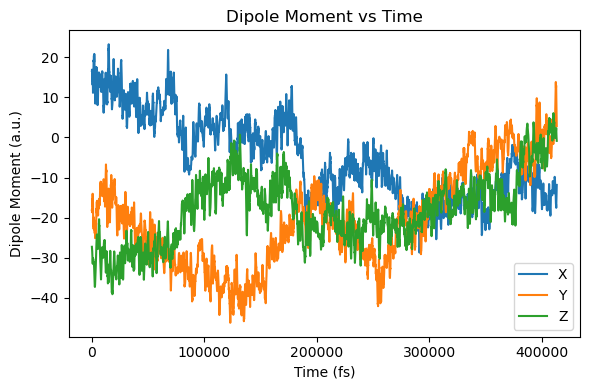

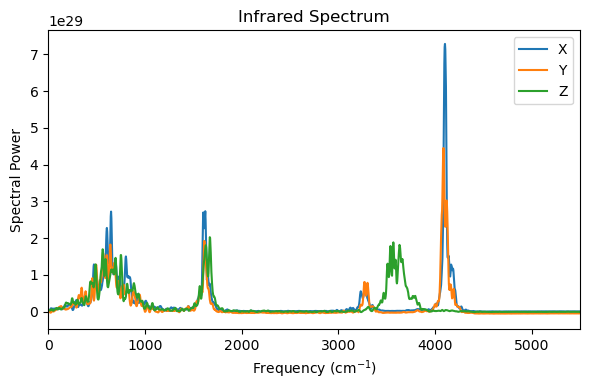

In [5]:
from maxwelllink.tools import ir_spectrum
import matplotlib.pyplot as plt

mux = np.array([ad["mux_m_au"] for ad in molecule.additional_data_history])[1:-1]
muy = np.array([ad["muy_m_au"] for ad in molecule.additional_data_history])[1:-1]
muz = np.array([ad["muz_m_au"] for ad in molecule.additional_data_history])[1:-1]
t = np.array([ad["time_au"] for ad in molecule.additional_data_history])[1:-1]

plt.figure(figsize=(6, 4))
plt.plot(t, mux, label="X")
plt.plot(t, muy, label="Y")
plt.plot(t, muz, label="Z")
plt.xlabel("Time (fs)")
plt.ylabel("Dipole Moment (a.u.)")
plt.title("Dipole Moment vs Time")
plt.legend()
plt.tight_layout()
plt.show()

freq, sp_x = ir_spectrum(mux, 0.5, field_description="square")
freq, sp_y = ir_spectrum(muy, 0.5, field_description="square")
freq, sp_z = ir_spectrum(muz, 0.5, field_description="square")

plt.figure(figsize=(6, 4))
plt.plot(freq, sp_x, label="X")
plt.plot(freq, sp_y, label="Y")
plt.plot(freq, sp_z, label="Z")
plt.xlim(0, 5500)
plt.xlabel("Frequency (cm$^{-1}$)")
plt.ylabel("Spectral Power")
plt.title("Infrared Spectrum")
plt.legend()
plt.tight_layout()

plt.show()



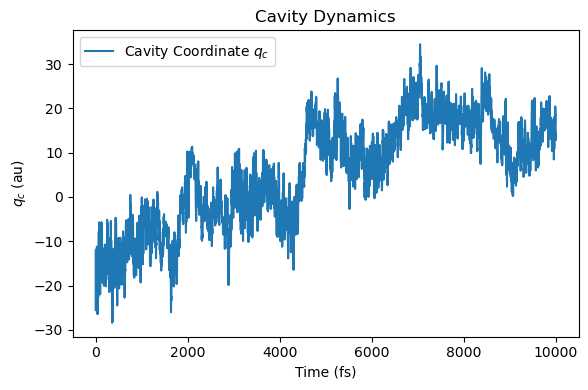

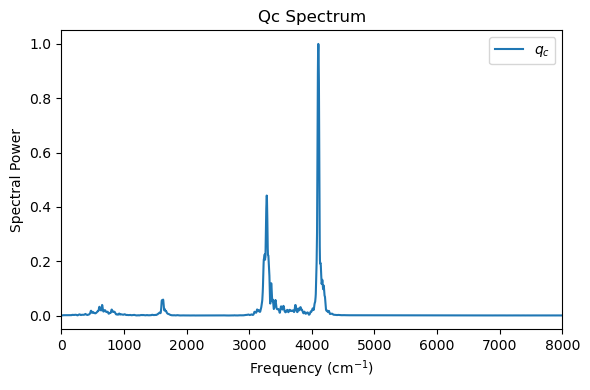

In [6]:
# plot cavity dynamics
au_to_fs = 41.3413745758
t = np.array(sim.time_history) / au_to_fs
# qc[0] is the x-direction cavity coordinate
qc = np.array([qc[0] for qc in sim.qc_history])

freq, sp_qc = ir_spectrum(qc, 0.5, field_description="square")


plt.figure(figsize=(6, 4))
plt.plot(t, qc, label="Cavity Coordinate $q_c$")
plt.xlabel("Time (fs)")
plt.ylabel("$q_c$ (au)")
plt.title("Cavity Dynamics")
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
plt.plot(freq, sp_qc / np.max(sp_qc), label="$q_c$")
plt.xlim(0, 8000)
plt.xlabel("Frequency (cm$^{-1}$)")
plt.ylabel("Spectral Power")
plt.title("Qc Spectrum")
plt.legend()
plt.tight_layout()
plt.show()

## 6. Energy conservation analysis

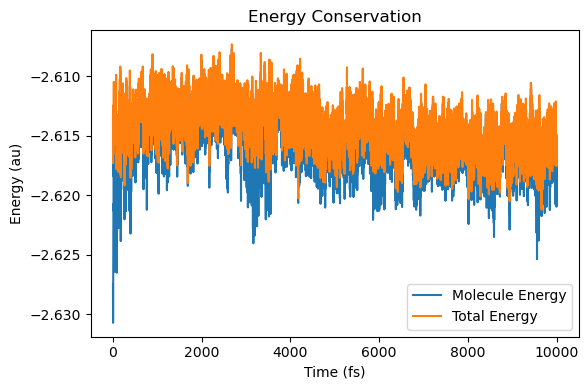

In [7]:
# This scheme does not fully conserve energy due to the use of prediction-correction of molecular states
# Better numerical schemes should be developed in the future

energy_molecule = np.array([ad["energy_au"] for ad in molecule.additional_data_history])
energy_tot = np.array(sim.energy_history)
energy_photon = energy_tot - energy_molecule

plt.figure(figsize=(6, 4))
plt.plot(t, energy_molecule, label="Molecule Energy")
plt.plot(t, energy_tot, label="Total Energy")
#plt.plot(t, energy_photon, label="Photon Energy")
plt.xlabel("Time (fs)")
plt.ylabel("Energy (au)")
plt.title("Energy Conservation")
plt.legend()
plt.tight_layout()
plt.show()
